## Reading data from CSV

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
import sqlite3 as lite

%matplotlib inline

# Read csv file into a dataframe.
try:
    df = pd.read_csv('Final_hour_dataset.csv', index_col=0)
except OSError:
    print("Filename not found!")
except Exception as e: print(e)

# index_col parmeter removes the 'unnamed column' which is added when reading from a csv
df.head()

,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount
0,3,B-004,160,2015-11-03 09:00:00,0.75,120,130,102.250000,120.5,62
1,1,B-002,90,2015-11-03 09:00:00,0.00,0,21,4.750000,2.0,2
2,2,B-003,90,2015-11-03 09:00:00,0.00,0,9,2.583333,2.0,2
3,3,B-004,160,2015-11-03 10:00:00,0.50,80,108,96.909091,102.0,53
4,1,B-002,90,2015-11-03 10:00:00,0.50,45,32,29.272727,29.0,28


In [7]:
df.shape

(216, 10)

In [8]:
df.dtypes

room_id               int64
Room                 object
Capacity              int64
Date                 object
SurveyPercentage    float64
GroundTruth         float64
MaxCount              int64
AverageCount        float64
MedianCount         float64
ModeCount             int64
dtype: object

In [9]:
df.isnull().sum()

room_id             0
Room                0
Capacity            0
Date                0
SurveyPercentage    0
GroundTruth         0
MaxCount            0
AverageCount        0
MedianCount         0
ModeCount           0
dtype: int64

We're trying to measure a relationship between connected WiFi hosts (MaxCount) and the ground truth data (Capacity * Survey Percentage) so we need a new column called 'GroundTruth'.

For now we only need a simple model so we will ignore module codes/students registered etc.

In [11]:
df['SurveyPercentage'] = df['SurveyPercentage'].apply(lambda x: x*100)

df.head()

,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount
0,3,B-004,160,2015-11-03 09:00:00,75,120,130,102.250000,120.5,62
1,1,B-002,90,2015-11-03 09:00:00,0,0,21,4.750000,2.0,2
2,2,B-003,90,2015-11-03 09:00:00,0,0,9,2.583333,2.0,2
3,3,B-004,160,2015-11-03 10:00:00,50,80,108,96.909091,102.0,53
4,1,B-002,90,2015-11-03 10:00:00,50,45,32,29.272727,29.0,28


### Measure correlation between connected devices and ground truth columns

In [13]:
df[['MaxCount', 'GroundTruth']].corr().as_matrix()[0,1]

0.70134791276394559

In [14]:
df[['AverageCount', 'GroundTruth']].corr().as_matrix()[0,1]

0.72596553734510105

In [15]:
df[['MedianCount', 'GroundTruth']].corr().as_matrix()[0,1]

0.74131596987918158

In [16]:
df[['ModeCount', 'GroundTruth']].corr().as_matrix()[0,1]

0.55880477891272762

Mediancount is more strongly correlated with GroundTruth so we will use this for our model.

### Training initial linear regression model

In [17]:
lm = sm.ols(formula="GroundTruth ~  MedianCount", data=df).fit()

# Print the model's parameters and weights
print(lm.params)

Intercept      7.526592
MedianCount    0.655154
dtype: float64


In [18]:
test_minmax = pd.DataFrame({'MedianCount': [df.MedianCount.min(), df.MedianCount.max()]})
test_minmax.head()

,MedianCount
0,0
1,225


In [19]:
predictions = lm.predict(test_minmax)
predictions

array([   7.52659244,  154.93627812])

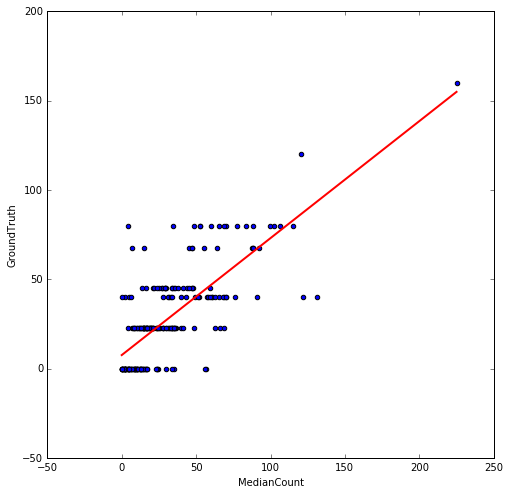

In [21]:
df.plot(kind='scatter', x='MedianCount', y='GroundTruth', figsize=(8, 8))

plt.plot(test_minmax, predictions, c='red', linewidth=2)

In [22]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GroundTruth   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     261.1
Date:                Thu, 04 Aug 2016   Prob (F-statistic):           6.38e-39
Time:                        12:28:57   Log-Likelihood:                -928.43
No. Observations:                 216   AIC:                             1861.
Df Residuals:                     214   BIC:                             1868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       7.5266      1.757      4.283      0.000         4.063    10.990
MedianCount     0.6552      0.041     16.158      0.000         0.575     0.735
==============================================================================
Omnibus:                       19.197   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.845
Skew:                           0.544   Prob(JB):                     5.45e-07
Kurtosis:                       4.422   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
df_train = df[:int((0.7*df.shape[0]))]
df_test = df[int((0.7*df.shape[0])):]

# split into training and test sets

In [24]:
lm = sm.ols(formula="GroundTruth ~  MedianCount", data=df_train).fit()

In [25]:
test_predictions = lm.predict(df_test)
test_predictions

array([ 14.40221095,  17.76335834,  54.73597968,  34.23298057,
        67.17222504,  12.72163725,  19.78004678,  66.8361103 ,
        15.7466699 ,  19.1078173 ,  33.22463636,  31.20794792,
        27.84680052,  10.36883407,   9.02437512,  23.81342365,
        22.46896469,  66.8361103 ,  11.04106355,  11.04106355,
        30.87183318,  26.50234157,  10.70494881,  47.67757015,
        27.51068579,  12.72163725,  41.96361958,  17.76335834,
        54.0637502 ,  63.81107764,  11.71329303,  18.43558782,
        42.9719638 ,  27.17457105,  20.45227626,   7.67991616,
        49.69425859,  16.41889938,  45.66088171,  40.28304588,
        15.7466699 ,  10.70494881,  11.71329303,  23.47730891,
        45.32476698,  12.38552251,  27.17457105,  30.53571844,
        15.07444043,  21.79673521,  11.04106355,  17.4272436 ,
        24.14953839,  23.14119417,  16.41889938,  19.1078173 ,
        84.98630623,  19.78004678,  38.26635745,  10.36883407,
        18.43558782,  35.24132479,   7.67991616,  13.39

In [26]:
df_test['Predictions'] = test_predictions

C:\Users\veldi_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
df_test.head()

,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount,Predictions
151,1,B-002,90,2015-11-11 11:00:00,25,22.5,21,10.909091,10.0,8,14.402211
152,2,B-003,90,2015-11-11 11:00:00,75,67.5,44,18.272727,15.0,7,17.763358
153,3,B-004,160,2015-11-11 12:00:00,25,40.0,75,60.333333,70.0,48,54.735980
154,1,B-002,90,2015-11-11 12:00:00,25,22.5,44,37.083333,39.5,24,34.232981
155,2,B-003,90,2015-11-11 12:00:00,75,67.5,97,81.500000,88.5,40,67.172225


In [28]:
#Pair the actual and the predicted values
print("Actual - Predicted:\n", (df_test['GroundTruth'] - df_test['Predictions']))
print("\n(Actual - Predicted) squared:\n", (df_test['GroundTruth'] - df_test['Predictions'])**2)

Actual - Predicted:
 151     8.097789
152    49.736642
153   -14.735980
154   -11.732981
155     0.327775
156   -12.721637
157     2.719953
158     0.663890
159   -15.746670
160   -19.107817
161    11.775364
162   -31.207948
163    -5.346801
164    12.131166
165    -9.024375
166    -1.313424
167    22.531035
168    13.163890
169   -11.041064
170   -11.041064
171    49.128167
172    -4.002342
173   -10.704949
174    -7.677570
175    -5.010686
176     9.778363
177    -1.963620
178     4.736642
179   -31.563750
180    16.188922
         ...    
186    32.320084
187   -27.194259
188     6.081101
189   -45.660882
190   -17.783046
191   -15.746670
192   -10.704949
193   -11.713293
194    21.522691
195   -45.324767
196   -12.385523
197    17.825429
198   -30.535718
199   -15.074440
200     0.703265
201   -11.041064
202   -17.427244
203    -1.649538
204   -23.141194
205   -16.418899
206   -19.107817
207    -4.986306
208     2.719953
209     6.733643
210    69.631166
211     4.064412
212   -12.

In [29]:
# Mean squared error on the test set
mse = ((df_test['GroundTruth'] - df_test['Predictions'])**2).mean()
print("\nMean Squared Error:\n", mse)


Mean Squared Error:
 428.91702692816347


In [30]:
print("Absolute value for Actual - Predicted:\n", abs((df_test['GroundTruth'] - df_test['Predictions'])))

Absolute value for Actual - Predicted:
 151     8.097789
152    49.736642
153    14.735980
154    11.732981
155     0.327775
156    12.721637
157     2.719953
158     0.663890
159    15.746670
160    19.107817
161    11.775364
162    31.207948
163     5.346801
164    12.131166
165     9.024375
166     1.313424
167    22.531035
168    13.163890
169    11.041064
170    11.041064
171    49.128167
172     4.002342
173    10.704949
174     7.677570
175     5.010686
176     9.778363
177     1.963620
178     4.736642
179    31.563750
180    16.188922
         ...    
186    32.320084
187    27.194259
188     6.081101
189    45.660882
190    17.783046
191    15.746670
192    10.704949
193    11.713293
194    21.522691
195    45.324767
196    12.385523
197    17.825429
198    30.535718
199    15.074440
200     0.703265
201    11.041064
202    17.427244
203     1.649538
204    23.141194
205    16.418899
206    19.107817
207     4.986306
208     2.719953
209     6.733643
210    69.631166
211     

In [31]:
# Mean absolute error. Surprisingly not bad!
mae = abs(df_test['GroundTruth'] - df_test['Predictions']).mean()
print("Mean absolute error is: \n{}".format(mae))

Mean absolute error is: 
15.57521924057233


### Creating bins for the 'Predictions' value

In [32]:
def classify_prediction(df, i):

    # passing in this: df2_test.Predictions[row], row
    prediction = df.Predictions[i]
    
    capacity = df.Capacity[i]
    # selects the relevant capacity value for the room and assigns to a variable
    percentile_0 = 0
#     percentile_25 = capacity * 0.25
    percentile_50 = capacity * 0.5
#     percentile_75 = capacity * 0.75
    percentile_100 = capacity
    
# This is going to be disgusting, I'd like to find a better way of doing it.
    
#     if prediction <= (percentile_25 - ((percentile_25 - percentile_0)/2)):
#         return 0
#     # if prediction is closer to 0% than 25%, return 0%
#     # in this case: if prediction(43) is less than (40 - ((40-0)/2))
#     # so between range of 0 to 20
#     elif prediction >= percentile_25 - ((percentile_25 - percentile_0)/2) and prediction <= percentile_50 - ((percentile_50 - percentile_25)/2):
#         return 25
#     # if prediction (43) is greater than 20 and less than 60
#     elif prediction >= percentile_50 - ((percentile_50 - percentile_25)/2) and prediction <= percentile_75 - ((percentile_75 - percentile_50)/2):
#         return 50
#     # if prediction is greater than 60 and less than 100
#     elif prediction >= percentile_75 - ((percentile_75 - percentile_50)/2) and prediction <= percentile_100 - ((percentile_100 - percentile_75)/2):
#         return 75
#     # if prediction is greater than 100 and less than 140
#     elif prediction >= percentile_100 - ((percentile_100 - percentile_75)/2):
#         return 100

# making ternary bins rather than original 0/25/50/75/100
    if prediction <= (percentile_50 - ((percentile_50 - percentile_0)/2)):
        return 0
    elif prediction >= percentile_50 - ((percentile_50 - percentile_0)/2) and prediction <= percentile_100 - ((percentile_100 - percentile_50)/2):
        return 50
    # if prediction (43) is greater than 20 and less than 60
    elif prediction >= percentile_100 - ((percentile_100 - percentile_50)/2):
        return 100

# roomdf2_test['PredictedPercentage'] = roomdf2_test['Predictions'].map(classify_prediction)
# roomdf2_test

df_test = df_test.reset_index(drop = True)
percentage = []

print("Shape of df_test is {}".format(df_test.shape))

for row in range(df_test.shape[0]):
    percentage.append(classify_prediction(df_test, row))

df_test['PredictedPercentage'] = percentage
df_test.head()

# my_series.apply((lambda x: your_func(a,b,c,d,...,x)))
# my_series.apply(your_function, args=(2,3,4), extra_kw=1)

# mapping values to new column
# http://stackoverflow.com/questions/21029128/updating-pandas-dataframe-via-for-loops

Shape of df_test is (65, 11)


,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount,Predictions,PredictedPercentage
0,1,B-002,90,2015-11-11 11:00:00,25,22.5,21,10.909091,10.0,8,14.402211,0
1,2,B-003,90,2015-11-11 11:00:00,75,67.5,44,18.272727,15.0,7,17.763358,0
2,3,B-004,160,2015-11-11 12:00:00,25,40.0,75,60.333333,70.0,48,54.735980,50
3,1,B-002,90,2015-11-11 12:00:00,25,22.5,44,37.083333,39.5,24,34.232981,50
4,2,B-003,90,2015-11-11 12:00:00,75,67.5,97,81.500000,88.5,40,67.172225,50


In [33]:
# testing accuracy of model excluding values that it currently doesn't account for
evaluation = df_test[(df_test.SurveyPercentage != 25) & (df_test.SurveyPercentage != 75)]
evaluation.head()

,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount,Predictions,PredictedPercentage
5,3,B-004,160,2015-11-11 13:00:00,0,0,9,7.400000,7.5,9,12.721637,0
8,3,B-004,160,2015-11-11 14:00:00,0,0,18,12.166667,12.0,9,15.746670,0
9,1,B-002,90,2015-11-11 14:00:00,0,0,22,16.416667,17.0,17,19.107817,0
10,2,B-003,90,2015-11-11 14:00:00,50,45,77,41.166667,38.0,77,33.224636,50
11,3,B-004,160,2015-11-11 15:00:00,0,0,39,35.250000,35.0,28,31.207948,0


In [34]:
surveyvsprediction = (evaluation.SurveyPercentage - evaluation.PredictedPercentage)
print("Actual - Predicted:\n", surveyvsprediction)

# 0 means the prediction matches the survey.
print("\nCorrect observations: ", (surveyvsprediction.tolist()).count(0), " out of ", len(surveyvsprediction.tolist()))
print("\nAccuracy score: ", (surveyvsprediction.tolist()).count(0)/len(surveyvsprediction.tolist())*100)

Actual - Predicted:
 5      0
8      0
9      0
10     0
11     0
14     0
16    50
17     0
18     0
19     0
20    50
22     0
29     0
30     0
31     0
32     0
33     0
38   -50
40     0
41     0
42     0
43     0
44   -50
45     0
46     0
47     0
48     0
50     0
51     0
53     0
54     0
55     0
56     0
58     0
59    50
62     0
dtype: float64

Correct observations:  31  out of  36

Accuracy score:  86.11111111111111


In [35]:
lm.summary()
# The weight for features MedianCount and Intercept are found to be statistically significant (p-value < 0.05)
# R-squared values are middling, variance explained by the model is not very high but this is fine as we are
# attempting to predict with high accuracy/low granulity rather than the converse.

# measuring mean squared error and mean absolute error doesn't make much sense with the binned predictions as
# the values are categorical.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GroundTruth   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     249.6
Date:                Thu, 04 Aug 2016   Prob (F-statistic):           1.20e-33
Time:                        12:34:05   Log-Likelihood:                -636.88
No. Observations:                 151   AIC:                             1278.
Df Residuals:                     149   BIC:                             1284.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       7.6799      1.925      3.990      0.000         3.877    11.483
MedianCount     0.6722      0.043     15.798      0.000         0.588     0.756
==============================================================================
Omnibus:                        6.507   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.468
Skew:                           0.242   Prob(JB):                       0.0145
Kurtosis:                       4.055   Cond. No.                         64.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
try:
    con = lite.connect('wicount.sqlite3')
    df_test.to_sql(con=con, name='analytics', if_exists='append', flavor='sqlite', index=False)
    # Set index to False because it's not a column but will be treated as one.
    print("Success! Table created or updated.")
except Exception as e: print(e)

# Problem at the moment: UNIQUE constraint failed: analytics.room_id, analytics.date
# Now using logdate instead of date as primary key.
# Writes fine otherwise.

Success! Table created or updated.


### General function to make and classify predictions

Should run a dataframe loaded from the database table

In [49]:
def make_predictions(df):
    wicountlm = sm.ols(formula="GroundTruth ~  MedianCount", data=df).fit()
    # Print the model's parameters and weights
    print(lm.params)
    
    predictions = wicountlm.predict(df)
    df['Predictions'] = predictions
    
    
    df = df.reset_index(drop = True)
    percentage = []


    for row in range(df.shape[0]):
        percentage.append(classify_prediction(df, row))
        
    print(df.shape)

    df['PredictedPercentage'] = percentage
    return df
    
# testing using the full dataset (with one row per class)
df.shape
make_predictions(df)
df.to_csv("brendans.csv")

Intercept      7.679916
MedianCount    0.672229
dtype: float64
(216, 11)


In [46]:
#velda added
#df2 = pd.DataFrame(columns=df.columns)
df2 = df.copy(deep=True)
df2.head(2)

,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount,Predictions
0,3,B-004,160,2015-11-03 09:00:00,75,120,130,102.25,120.5,62,86.472669
1,1,B-002,90,2015-11-03 09:00:00,0,0,21,4.75,2.0,2,8.836901


In [47]:
#df2 = pd.DataFrame(columns=df.columns)

test_predictions = lm.predict(df2)
test_predictions

df2['Predictions'] = test_predictions



#print("Actual - Predicted:\n", (df2['GroundTruth'] - df2['Predictions']))
#print("\n(Actual - Predicted) squared:\n", (df2['GroundTruth'] - df2['Predictions'])**2)

# Mean squared error on the test set
mse = ((df2['GroundTruth'] - df2['Predictions'])**2).mean()
print("\nMean Squared Error:\n", mse)

#print("Absolute value for Actual - Predicted:\n", abs((df2['GroundTruth'] - df2['Predictions'])))

mae = abs(df2['GroundTruth'] - df2['Predictions']).mean()
print("Mean absolute error is: \n{}".format(mae))


Mean Squared Error:
 317.68001523944594
Mean absolute error is: 
13.620105513924129


In [32]:
def classify_prediction(df, i):

    # passing in this: df2_test.Predictions[row], row
    prediction = df.Predictions[i]
    
    capacity = df.Capacity[i]
    # selects the relevant capacity value for the room and assigns to a variable
    percentile_0 = 0
    percentile_25 = capacity * 0.25
    percentile_50 = capacity * 0.5
    percentile_75 = capacity * 0.75
    percentile_100 = capacity
    
# This is going to be disgusting, I'd like to find a better way of doing it.
    
#     if prediction <= (percentile_25 - ((percentile_25 - percentile_0)/2)):
#         return 0
#     # if prediction is closer to 0% than 25%, return 0%
#     # in this case: if prediction(43) is less than (40 - ((40-0)/2))
#     # so between range of 0 to 20
#     elif prediction >= percentile_25 - ((percentile_25 - percentile_0)/2) and prediction <= percentile_50 - ((percentile_50 - percentile_25)/2):
#         return 25
#     # if prediction (43) is greater than 20 and less than 60
#     elif prediction >= percentile_50 - ((percentile_50 - percentile_25)/2) and prediction <= percentile_75 - ((percentile_75 - percentile_50)/2):
#         return 50
#     # if prediction is greater than 60 and less than 100
#     elif prediction >= percentile_75 - ((percentile_75 - percentile_50)/2) and prediction <= percentile_100 - ((percentile_100 - percentile_75)/2):
#         return 75
#     # if prediction is greater than 100 and less than 140
#     elif prediction >= percentile_100 - ((percentile_100 - percentile_75)/2):
#         return 100

# making ternary bins rather than original 0/25/50/75/100
    if prediction <= (percentile_50 - ((percentile_50 - percentile_0)/2)):
        return 0
    elif prediction >= percentile_50 - ((percentile_50 - percentile_0)/2) and prediction <= percentile_100 - ((percentile_100 - percentile_50)/2):
        return 50
    # if prediction (43) is greater than 20 and less than 60
    elif prediction >= percentile_100 - ((percentile_100 - percentile_50)/2):
        return 100

# roomdf2_test['PredictedPercentage'] = roomdf2_test['Predictions'].map(classify_prediction)
# roomdf2_test

#df_test = df_test.reset_index(drop = True)
#percentage = []

print("Shape of df_test is {}".format(df_test.shape))

for row in range(df2.shape[0]):
    percentage.append(classify_prediction(df2, row))

df2['PredictedPercentage'] = percentage
df2.head()

# my_series.apply((lambda x: your_func(a,b,c,d,...,x)))
# my_series.apply(your_function, args=(2,3,4), extra_kw=1)

# mapping values to new column
# http://stackoverflow.com/questions/21029128/updating-pandas-dataframe-via-for-loops

Shape of df_test is (65, 11)


,room_id,Room,Capacity,Date,SurveyPercentage,GroundTruth,MaxCount,AverageCount,MedianCount,ModeCount,Predictions,PredictedPercentage
0,1,B-002,90,2015-11-11 11:00:00,25,22.5,21,10.909091,10.0,8,14.402211,0
1,2,B-003,90,2015-11-11 11:00:00,75,67.5,44,18.272727,15.0,7,17.763358,0
2,3,B-004,160,2015-11-11 12:00:00,25,40.0,75,60.333333,70.0,48,54.735980,50
3,1,B-002,90,2015-11-11 12:00:00,25,22.5,44,37.083333,39.5,24,34.232981,50
4,2,B-003,90,2015-11-11 12:00:00,75,67.5,97,81.500000,88.5,40,67.172225,50


In [48]:
df2.to_csv("df2a.csv")